This notebook performs the synthesis using our proposed synthesization approach applied to the South Korean COVID-19 data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [4]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import sys
import os
import pickle

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

# Add the parent directory to path
sys.path.append('..')

# Then import
from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

In [3]:
train_data

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,5,0
1,0.889746,-0.694899,1,5,0
2,0.917482,-0.682299,1,3,0
3,0.916660,-0.682551,1,3,0
4,0.886074,-0.668883,1,3,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,4,0
6708,-1.728784,1.470871,1,4,0
6709,-1.548071,1.557316,1,4,0
6710,-1.549392,1.555785,1,4,0


***

# Full Sequential Synthesis Driven by Bayesian Optimization

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [4]:
def train_models(#overall parameters
                 train_data,
                 number_synthetic_datasets,
                 # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                 number_gmm_initializations,
                 num_components_,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_sex_,
                 mb_age_,
                 mb_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)
    
    cart_sex.fit(X=train_data.loc[:,["latitude", "longitude"]], y=train_data.loc[:,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data.loc[:,["latitude", "longitude"]]).toarray()
    
    node_outcomes = [train_data.sex[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,["latitude", "longitude"]])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ####################################################################################################
        
    ########### Code for age CART ##########
    cart_age = DecisionTreeClassifier(min_samples_leaf=mb_age_, random_state=rng)
    
    cart_age.fit(X=train_data.loc[:,["latitude", "longitude", "sex"]], y=train_data.loc[:,"age"])
    
    node_indicators = cart_age.decision_path(train_data.loc[:,["latitude", "longitude", "sex"]]).toarray()
    
    node_outcomes = [train_data.age[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_age.apply(sXs[i].loc[:,["latitude", "longitude", "sex"]])
        
        new_age = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_age[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_age = pd.Series(new_age)
        
        new_age.name = "age"
        
        sXs[i] = pd.concat([sXs[i], new_age], axis=1)
        
    ####################################################################################################
    
    ########### Code for state CART ##########
    
    cart_state = DecisionTreeClassifier(min_samples_leaf=mb_state_, random_state=rng)
    
    cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])
    
    node_indicators = cart_state.decision_path(train_data.loc[:,["latitude", "longitude", "sex", "age"]]).toarray()
    
    node_outcomes = [train_data.state[node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        # bst_vals = [bayesian_bootstrap(X=np.array(x), 
        #                                statistic=stat,
        #                                n_replications=1,
        #                                resample_size=len(x))[0] for x in node_outcomes]
        
        synth_leaves = cart_state.apply(sXs[i].loc[:,["latitude", "longitude", "sex", "age"]])
        
        new_state = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_state[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_state = pd.Series(new_state)
        
        new_state.name = "state"
        
        sXs[i] = pd.concat([sXs[i], new_state], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    
    return pmse_ratios, sXs, GMM

In [5]:
def optimize_models(train_data,
                    number_synthetic_datasets,
                    number_gmm_initializations,
                    random_state):

    def evaluate_models(num_components_, mb_sex_, mb_age_, mb_state_):

        pmse_ratios, current_sXs, current_GMM = train_models(train_data=train_data,
                                                             number_synthetic_datasets=number_synthetic_datasets,
                                                             number_gmm_initializations=number_gmm_initializations,
                                                             num_components_=int(num_components_),
                                                             mb_sex_=int(mb_sex_),
                                                             mb_age_=int(mb_age_),
                                                             mb_state_=int(mb_state_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "mb_sex_": (10, 350.99),
            "mb_age_": (10, 350.99),
            "mb_state_": (10, 350.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [6]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [7]:
optimization_results = [optimize_models(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------
| 1         | -0.3922   | 263.4     | 87.21     | 229.1     | 178.5     |
| 2         | -0.2783   | 262.6     | 255.9     | 110.7     | 110.4     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 3         | -0.5648   | 69.25     | 286.9     | 299.6     | 58.99     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 4         | -0.1694   | 90.89     | 166.3     | 88.06     | 48.58     |
| 5         | -1.147    | 345.1     | 344.4     | 260.6     | 88.17     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 6         | -0.2949   | 88.34     | 160.9     | 84.16     | 65.68     |
| 7         | -0.5888   | 258.9     | 256.3     | 96.8      | 102.4     |
| 8         | -0.06193  | 102.9     | 169.1     | 76.1      | 51.73     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 9         | -0.2097   | 108.5     | 174.9     | 73.49     | 34.94     |
| 10        | -0.3026   | 127.4     | 179.4     | 82.42     | 64.44     |
| 11        | -0.07661  | 88.46     | 179.0     | 59.96     | 55.75     |
| 12        | -0.2606   | 134.1     | 81.26     | 86.05     | 70.97     |
| 13        | -0.3831   | 158.4     | 122.7     | 200.6     | 95.38     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 14        | -0.03558  | 104.0     | 170.9     | 30.38     | 64.57     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 15        | -1.072    | 172.4     | 198.9     | 343.8     | 142.6     |
| 16        | -0.202    | 103.1     | 157.6     | 48.69     | 53.66     |
| 17        | -0.01526  | 100.7     | 192.5     | 33.61     | 70.38     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 18        | -1.438    | 309.2     | 70.67     | 190.7     | 24.39     |
| 19        | -0.5948   | 234.9     | 108.1     | 238.6     | 200.3     |
| 20        | -0.8292   | 331.6     | 57.67     | 139.2     | 147.0     |
| 21        | -0.1833   | 82.37     | 168.9     | 85.15     | 52.51     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 22        | -0.5544   | 124.4     | 85.62     | 91.61     | 71.97     |
| 23        | -0.07333  | 161.3     | 69.05     | 70.06     | 68.22     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 24        | -0.396    | 271.0     | 254.6     | 144.1     | 131.1     |
| 25        | -0.03641  | 92.78     | 181.8     | 10.0      | 80.19     |
| 26        | -0.07049  | 98.26     | 159.3     | 79.99     | 53.28     |
| 27        | -0.07174  | 126.9     | 171.8     | 75.02     | 61.72     |
| 28        | -0.08496  | 104.8     | 170.0     | 83.82     | 47.54     |
| 29        | -0.08613  | 131.9     | 151.2     | 72.5      | 54.06     |
| 30        | -0.1123   | 106.6     | 179.6     | 73.02     | 34.98     |
Final Result:  {'target': -0.015255385121079103, 'params': {'mb_age_': 100.6938312316058, 'mb_sex_': 192.49912161575594, 'mb_state_': 33.60751028414454, 'num_components_': 70.3769065456829}}
|   iter    |  target   |  mb_age_  |  mb_sex_  | mb_state_ | num_co... |
-------------------------------------------------------------------------
| 1         | -0.8957   | 289.1     | 308.2     | 152.7     | 95.03     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 2         | -0.1817   | 53.83     | 45.79     | 230.3     | 193.8     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

| 3         | -0.4054   | 109.1     | 32.75     | 178.0     | 86.85     |
| 4         | -0.1621   | 84.31     | 294.6     | 72.11     | 89.95     |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 5         | -0.06208  | 115.5     | 346.5     | 23.93     | 66.4      |


C:\Users\Cameron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 6         | -0.07964  | 49.16     | 351.0     | 10.0      | 48.46     |
| 7         | -0.02809  | 79.97     | 285.0     | 70.82     | 96.69     |
| 8         | -0.2774   | 63.96     | 52.45     | 228.9     | 196.0     |
| 9         | -0.03076  | 75.96     | 284.3     | 60.11     | 107.8     |
| 10        | -0.03317  | 72.53     | 261.6     | 76.45     | 103.1     |
| 11        | -0.1075   | 95.36     | 247.4     | 57.22     | 85.61     |
| 12        | -0.2247   | 92.49     | 274.2     | 79.72     | 117.7     |
| 13        | -0.08056  | 46.06     | 285.7     | 63.68     | 106.5     |
| 14        | -0.02338  | 59.9      | 263.2     | 61.06     | 79.65     |
| 15        | -0.002618 | 47.01     | 348.0     | 15.09     | 41.0      |
| 16        | -0.5194   | 44.26     | 340.0     | 27.72     | 18.82     |
| 17        | -0.1036   | 67.01     | 275.9     | 66.09     | 82.31     |
| 18        | -0.19     | 92.29     | 239.4     | 56.39     | 87.99     |
| 19        | -0.04526  | 74.59     | 

***

In [15]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

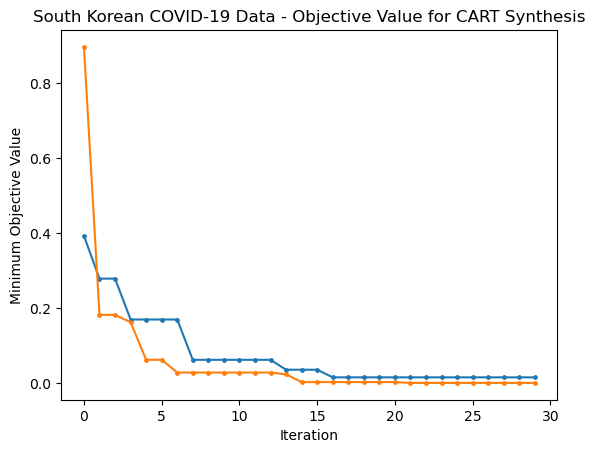

In [9]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("South Korean COVID-19 Data - Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
fig.savefig('../Images/min_objective_cart_sk.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -0.0004114788167408786,
 'params': {'mb_age_': 28.91938808937796,
  'mb_sex_': 255.94300832168977,
  'mb_state_': 50.44876862575522,
  'num_components_': 73.18789813346086}}

***

In [16]:
pmse_ratios, full_sXs, GMM = train_models(train_data=train_data,
                                          number_synthetic_datasets=20,
                                          # hyperparameters for GMM
                                          number_gmm_initializations=ngi,
                                          num_components_=int(best_params['params']['num_components_']),
                                          # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                          mb_sex_=int(best_params['params']['mb_sex_']),
                                          mb_age_=int(best_params['params']['mb_age_']),
                                          mb_state_=int(best_params['params']['mb_state_']))

In [17]:
np.mean(pmse_ratios)

1.049889933797527

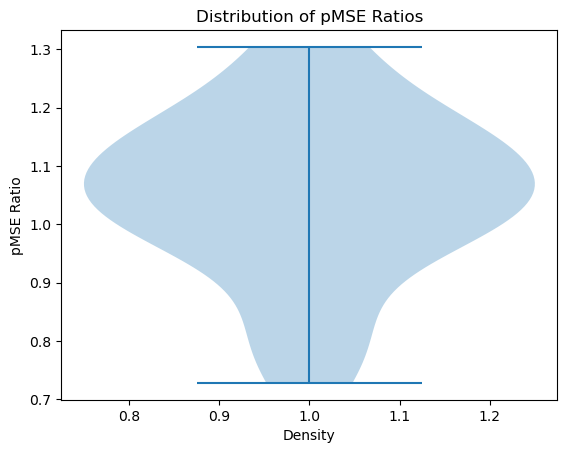

In [18]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

In [4]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv", index=False)

# save
os.makedirs("../Results/SK/Models/", exist_ok=True)
with open('../Results/SK/Models/gmm_and_cart.pkl','wb') as f:
    pickle.dump(GMM, f)

NameError: name 'full_sXs' is not defined

***

Import data sets if running from this point.

In [1]:
# full_sXs = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

# # load
# with open('../Results/SK/Models/gmm_and_cart.pkl', 'rb') as f:
#     GMM = pickle.load(f)

Now apply the attribute disclosure prevention algorithm.

Based on publicly available data from the World Health Organization, we use the total number of confirmed COVID-19 cases (9,583) and total number of deaths (152) in South Korea as of March 23, 2020 to calculate the prior probability $p(S_j = 1 | x_j^q, b) = 152/9583 \approx 0.016$ and $p(S_j = 0 | x_j^q, b) = 1 - 0.016 = 0.984$..984.

In [2]:
# prior = 152/9583

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the correct disease status based on the synthetic data. This is a relatively large increase. For example, this means going from 0.016 under the prior to no more than 0.16 under the updated probability.

In [3]:
# c = 10

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [4]:
# deltas = np.linspace(0.001, 1, 5)

***

In [5]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['latitude', 'longitude'],
#                                          categorical_vars=['sex', 'age'],
#                                          sensitive_var='state',
#                                          num_mixture_components=int(best_params['params']['num_components_']),
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

In [6]:
# for i, sX in enumerate(ad_sXs):
#     sX.to_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***

How many records did the attribute disclosure algorithm add, on average.

In [7]:
# ad_sXs = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [8]:
# num_records = train_data.shape[0]

In [9]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])